In [75]:
import numpy as np

class State:
    def __init__(self, board_size=3, pieces=None, enemy_pieces=None):
        self.board_size = board_size
        self.pieces = np.zeros(board_size * board_size, dtype=int) if pieces is None else np.array(pieces)
        self.enemy_pieces = np.zeros(board_size * board_size, dtype=int) if enemy_pieces is None else np.array(enemy_pieces)

    def piece_count(self, pieces):
        return np.sum(pieces)

    def is_lose(self):
        board = self.enemy_pieces.reshape(self.board_size, self.board_size)

        return any(
            np.all(line == 1) for line in
            np.vstack([
                board,  # 행
                board.T,  # 열
                np.diag(board),  # 대각선
                np.diag(np.fliplr(board))  # 반대 대각선
            ])
        )

    def is_draw(self):
        return np.sum(self.pieces + self.enemy_pieces) == self.board_size * self.board_size

    def is_done(self):
        # 종료 조건: 상대방이 승리 or 무승부
        return self.is_lose() or self.is_draw()

    def next(self, action):
        # 현재 상태에서 주어진 action(칸)에 말을 놓은 후 다음 상태 반환
        pieces = self.pieces.copy()
        pieces[action] = 1
        return State(self.board_size, self.enemy_pieces, pieces)

    def legal_actions(self):
        # 가능한 행동(빈 칸의 위치)을 반환
        return np.where((self.pieces + self.enemy_pieces) == 0)[0]

    def to_feature(self):
        # 상태를 신경망 입력 형태로 변환 (2, board_size, board_size)
        return np.stack([
            self.pieces.reshape(self.board_size, self.board_size),
            self.enemy_pieces.reshape(self.board_size, self.board_size)
        ], axis=0)

    def __str__(self):
        ox = ('o', 'x') if np.sum(self.pieces) == np.sum(self.enemy_pieces) else ('x', 'o')
        board = np.full(self.board_size * self.board_size, '-')
        board[self.pieces == 1] = ox[0]
        board[self.enemy_pieces == 1] = ox[1]
        return '\n'.join([
            ''.join(board[i:i + self.board_size]) for i in range(0, self.board_size * self.board_size, self.board_size)
        ])


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        shortcut = x # 입력 : x
        x = F.relu(self.bn1(self.conv1(x))) # F(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + shortcut) # F(x) + x

class DualNetwork(nn.Module):
    def __init__(self, board_size, input_channels=2, n_filters=128, n_res_blocks=16):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, n_filters, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(n_filters) for _ in range(n_res_blocks)]
        ) # 잔차 연결
        self.global_pool = nn.AdaptiveAvgPool2d(1) # (n_filters×1×1)

        # policy head
        self.policy_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, board_size * board_size),  # (배치크기, 9)
            nn.Softmax(dim=1)
        )
        # value head
        self.value_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, 1),   # (배치크기,1)
            nn.Tanh()
        )

    def forward(self, x):
        # input x : (배치 크기, 채널, 보드 크기, 보드 크기)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res_blocks(x)
        x = self.global_pool(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value # 행동 확률 분포, 상태의 가치

In [73]:
from math import sqrt

C_PCUT = 1.25 # 탐험과 탐욕적 행동 선택 균형

class MCTSNode:
    def __init__(self, state, p, c_puct=C_PCUT):
        self.state = state
        self.p = p # 신경망에서 예측한 정책 확률
        self.w = 0 # 노드 누적 보상
        self.n = 0 # 노드 방문 횟수
        self.c_puct = c_puct
        self.child_nodes = None

    def evaluate(self, model):
        if self.state.is_done(): # 종료 상태인지 확인
            value = -1 if self.state.is_lose() else 0 # 패배: -1, 무승부: 0
            self.w += value
            self.n += 1
            return value

        if not self.child_nodes:
            # 신경망으로 정책 및 가치 예측
            policies, value = predict(model, self.state, self.state.board_size)
            self.w += value
            self.n += 1
            # 자식 노드 생성
            self.child_nodes = [
                MCTSNode(self.state.next(action), policy, c_puct=self.c_puct)
                for action, policy in zip(self.state.legal_actions(), policies)
            ]
            return value

        # 자식 노드 평가
        value = -self.next_child_node().evaluate(model)
        self.w += value
        self.n += 1
        return value

    def next_child_node(self):
        # PUCT 탐색 알고리즘
        t = sum(child.n for child in self.child_nodes)
        pucb_values = [
            (-child.w / child.n if child.n else 0.0) +
            self.c_puct * child.p * sqrt(t) / (1 + child.n)
            for child in self.child_nodes
        ]
        return self.child_nodes[np.argmax(pucb_values)] # PUCT 값이 최대인 자식 노드를 선택


def predict(model, state, board_size):
    # 입력 데이터 정규화
    x = np.array([state.pieces, state.enemy_pieces], dtype=np.float32) / 1.0
    x = x.reshape(2, board_size, board_size).transpose(0, 1, 2).reshape(1, 2, board_size, board_size)
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    with torch.no_grad():
        policy, value = model(x_tensor) # 신경망으로 정책 및 가치 예측
        policy = policy.cpu().numpy().flatten() # 1차원으로 변환
        value = value.cpu().numpy().flatten()

    legal_actions = state.legal_actions()
    policies = policy[legal_actions]
    policy_sum = policies.sum()
    if policy_sum > 0:
        policies /= policy_sum
    else:
        policies = np.ones_like(policies) / len(policies)

    return policies, value[0]


def mcts_simulation(root_node, model, simulations=100):
    for _ in range(simulations):
        root_node.evaluate(model)

    # 방문 횟수 기준 정책 계산
    child_visits = [child.n for child in root_node.child_nodes]
    policy = np.array(child_visits) / sum(child_visits)
    return root_node, policy # 현재 게임 상태, 정책

In [54]:
def pad_policy(policy, legal_actions, board_size):
    # legal actions)에 대한 확률만 포함->보드 크기와 동일한 형태로 맞춤
    full_policy = np.zeros(board_size * board_size, dtype=np.float32)
    full_policy[legal_actions] = policy
    return full_policy

def self_play_game(model, board_size=3, simulations=100):
    state = State(board_size=board_size)
    game_data = []

    while not state.is_done():
        root_node = MCTSNode(state, p=1.0)
        root_node, policy = mcts_simulation(root_node, model, simulations)

        # 정책을 고정 크기로 변환
        padded_policy = pad_policy(policy, state.legal_actions(), board_size)

        game_data.append((state.to_feature(), padded_policy))

        action = np.random.choice(len(policy), p=policy)
        state = state.next(action)

    reward = 1 if not state.is_lose() else -1
    game_data = [(s, p, reward) for s, p in game_data]
    return game_data

In [74]:
def train_model(model, optimizer, game_data, epochs=1, batch_size=64):
    model.train()
    loss_fn_policy = torch.nn.CrossEntropyLoss()
    loss_fn_value = torch.nn.MSELoss()

    # 데이터를 PyTorch 텐서로 변환
    states, policies, values = zip(*game_data)
    states = torch.tensor(states, dtype=torch.float32).to(device)
    policies = torch.tensor(policies, dtype=torch.float32).to(device)
    values = torch.tensor(values, dtype=torch.float32).unsqueeze(1).to(device)

    dataset = torch.utils.data.TensorDataset(states, policies, values)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss, total_policy_accuracy, total_value_loss = 0, 0, 0

        for batch_states, batch_policies, batch_values in data_loader:
            optimizer.zero_grad()
            predicted_policies, predicted_values = model(batch_states)

            # 손실 계산
            loss_policy = loss_fn_policy(predicted_policies, batch_policies)
            loss_value = loss_fn_value(predicted_values, batch_values)
            loss = loss_policy + loss_value

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()

            # 정확도 계산 (신경망, MCTS)
            policy_accuracy = (predicted_policies.argmax(dim=1) == batch_policies.argmax(dim=1)).float().mean().item()

            total_loss += loss.item()
            total_policy_accuracy += policy_accuracy
            total_value_loss += loss_value.item()

        # 에포크별 평균 기록
        training_metrics["loss"].append(total_loss / len(data_loader))
        training_metrics["policy_accuracy"].append(total_policy_accuracy / len(data_loader))
        training_metrics["value_loss"].append(total_value_loss / len(data_loader))

In [56]:
def evaluate_models(new_model, old_model, games=20, board_size=3):
    new_wins, old_wins = 0, 0

    for _ in range(games):
        state = State(board_size=board_size)
        current_player = new_model

        while not state.is_done():
            root_node = MCTSNode(state, p=1.0)
            root_node, policy = mcts_simulation(root_node, current_player, simulations=100)

            action = np.argmax(policy)
            state = state.next(action)

            # 플레이어 교체
            current_player = old_model if current_player == new_model else new_model

        if state.is_lose():
            if current_player == new_model:
                old_wins += 1
            else:
                new_wins += 1

    # 승리 결과 기록
    evaluation_metrics["new_model_wins"].append(new_wins)
    evaluation_metrics["old_model_wins"].append(old_wins)
    return new_wins, old_wins

In [57]:
import matplotlib.pyplot as plt

def plot_training_metrics():
    # 손실 및 정책 정확도 그래프
    plt.figure(figsize=(15, 5))

    # 1. 정책 정확도 그래프
    plt.subplot(1, 3, 1)
    plt.plot(training_metrics["policy_accuracy"], label="Policy Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Policy Accuracy Over Epochs")
    plt.legend()

    # 2. 손실 그래프 (전체 손실과 가치 손실)
    plt.subplot(1, 3, 2)
    plt.plot(training_metrics["loss"], label="Total Loss", marker="o")
    plt.plot(training_metrics["value_loss"], label="Value Loss", marker="x")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # 3. 승률 그래프 (새 모델 vs 기존 모델 승리 횟수)
    plt.subplot(1, 3, 3)
    plt.plot(evaluation_metrics["new_model_wins"], label="New Model Wins", marker="o")
    plt.plot(evaluation_metrics["old_model_wins"], label="Old Model Wins", marker="x")
    plt.xlabel("Iterations")
    plt.ylabel("Wins")
    plt.title("Model Evaluation Results")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [59]:
BOARD_SIZE = 3
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
SIMULATIONS = 100
GAMES_PER_ITERATION = 10
EVALUATION_GAMES = 10
ITERATIONS = 10

Iteration 1
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 2
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 3
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 4
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 5
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 6
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 7
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 8
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 9
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.
Iteration 10
New Model Wins: 0, Old Model Wins: 10
Old model is better. Retaining old model.


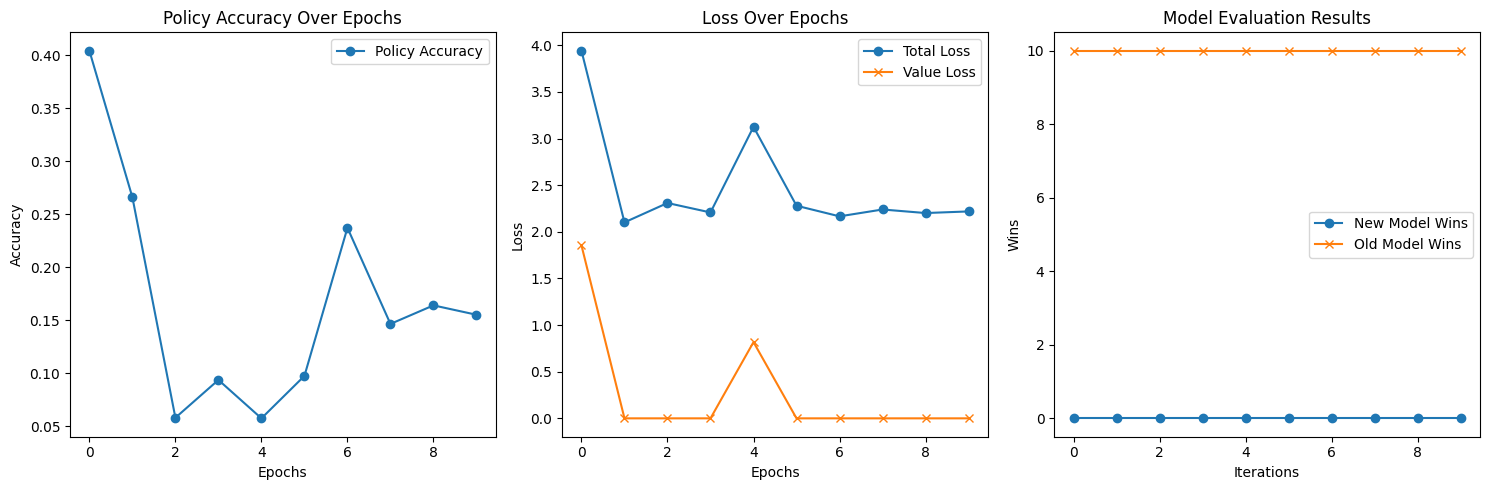

In [61]:
import torch.optim as optim

model = DualNetwork(BOARD_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

old_model = DualNetwork(BOARD_SIZE).to(device)
old_model.load_state_dict(model.state_dict())

training_metrics = {
    "loss": [],
    "policy_accuracy": [],
    "value_loss": []
}

evaluation_metrics = {
    "new_model_wins": [],
    "old_model_wins": []
}

for iteration in range(ITERATIONS):
    print(f"Iteration {iteration + 1}")

    game_data = []
    for _ in range(GAMES_PER_ITERATION):
        game_data += self_play_game(model, BOARD_SIZE, simulations=SIMULATIONS)

    train_model(model, optimizer, game_data, epochs=1)

    new_wins, old_wins = evaluate_models(model, old_model, games=EVALUATION_GAMES)
    print(f"New Model Wins: {new_wins}, Old Model Wins: {old_wins}")

    if new_wins > old_wins:
        old_model.load_state_dict(model.state_dict())
        print("New model is better and replaced the old model.")
    else:
        print("Old model is better. Retaining old model.")

plot_training_metrics()
